<a href="https://colab.research.google.com/github/ShimminS096/material_computer_cross/blob/main/dnn_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Hyperparameter Setting**


*   Dataset_Structure : train_dataset(64%)|vaildation_dataset(16%)|test_dataset(20%)
*   Dataset_Filename : Filtered_Dataset.npz
*   Label_Filename : Ground Truth.csv
*   Input_Size : 301
*   Hidden_Size : [100, 100, 50]









# 1. Data loading & Dataset setting



  1-1. Load dataset

In [67]:

# Setting
# ['Vth', 'Mobility', 'S-Slope', 'OnOff']
SELECTED_LABEL = 'OnOff'

EPOCHS = 1000
BATCH_SIZE = 128
RANDOM_STATE = 24
PATIENCE = 100
LEARNING_RATE = 0.001

OPTIMIZER_NAME = 'adam'
LOSS_FUNCTION = 'mse'
PERFORMANCE = ['mse', 'mae', 'mape']
ACTIVATION_FUNCTION = 'relu'

if(SELECTED_LABEL == 'OnOff'):
  NORMALIZATION = 'norm_log10'
else:
  NORMALIZATION = 'norm'

REGULARIZATION = 0  # 0이면 없는 것과 같음
REGULARIZATION_NAME = regularizers.l2(REGULARIZATION)
DROP_OUT = 0 # [0,1) <- 0이면 dropout하지 않은 것과 같음





In [68]:
import numpy as np
import pathlib
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from datetime import datetime
print(tf.__version__)

from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Activation, Dropout
from keras.metrics import Accuracy, SparseCategoricalAccuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# For saving hyperparameter of model
from google.colab import drive
drive.mount('/content/drive')

# Google Drive folder dir
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S_%f')
folder_path = f"/content/drive/My Drive/DNN_Hyperparameter/'{SELECTED_LABEL}'_'{timestamp}'"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Making hyperparameter & result data
def save_data_to_file(data, folder_path):
    # filename -> timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S_%f')
    file_name = f'data_{timestamp}.txt'
    file_path = os.path.join(folder_path, file_name)

    # txt 파일로 데이터 저장
    with open(file_path, 'w') as file:
        file.write(data)

    print(f"Data has been saved to {file_path}")

def save_plot_to_file(plot_figure, folder_path):
    # 현재 시간으로 파일 이름 생성
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S_%f')
    file_name = f'plot_{timestamp}.png'
    file_path = os.path.join(folder_path, file_name)

    plot_figure.savefig(file_path)
    print(f"Plot has been saved to {file_path}")

#------------------------------------------------------------------------



2.15.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Hyperparameter Setting

In [69]:

# Load dataset
# Convert array type : Numpy -> Pandas(DataFrame)
# Delete unused columns from array
dataset_column_names = [str(i) for i in range(301)]
label_column_names = ['index', 'Vth', 'Mobility', 'S-Slope', 'OnOff']
uploaded_dataset_label_path = 'Ground Truth.csv'
dataset = np.load('Filtered_Dataset.npz')['dataset']
dataset = pd.DataFrame(dataset)
label_dataset = pd.read_csv(uploaded_dataset_label_path, names = label_column_names,
                          na_values="?", comment='\t', skipinitialspace=True)
label_dataset.drop(label_dataset.columns[0], axis=1, inplace=True)

1-2. Setting input data

In [70]:

# Make One-hot Vector label data
# Split WANTED label column from label_dataset(Vth, Mobility, SS, On/Off)
label = label_dataset[SELECTED_LABEL].copy()
label = label.drop(0)
label = label.reset_index(drop=True)
label = label.astype(float)
# Make dataset used for model [ measured feature (idx:0~300) | mobility (idx:301)]
dataset = pd.concat([dataset, label], axis=1)
train_dataset = dataset.sample(frac=0.8,random_state=RANDOM_STATE)
test_dataset = dataset.drop(train_dataset.index)


1-3. Visualize input data

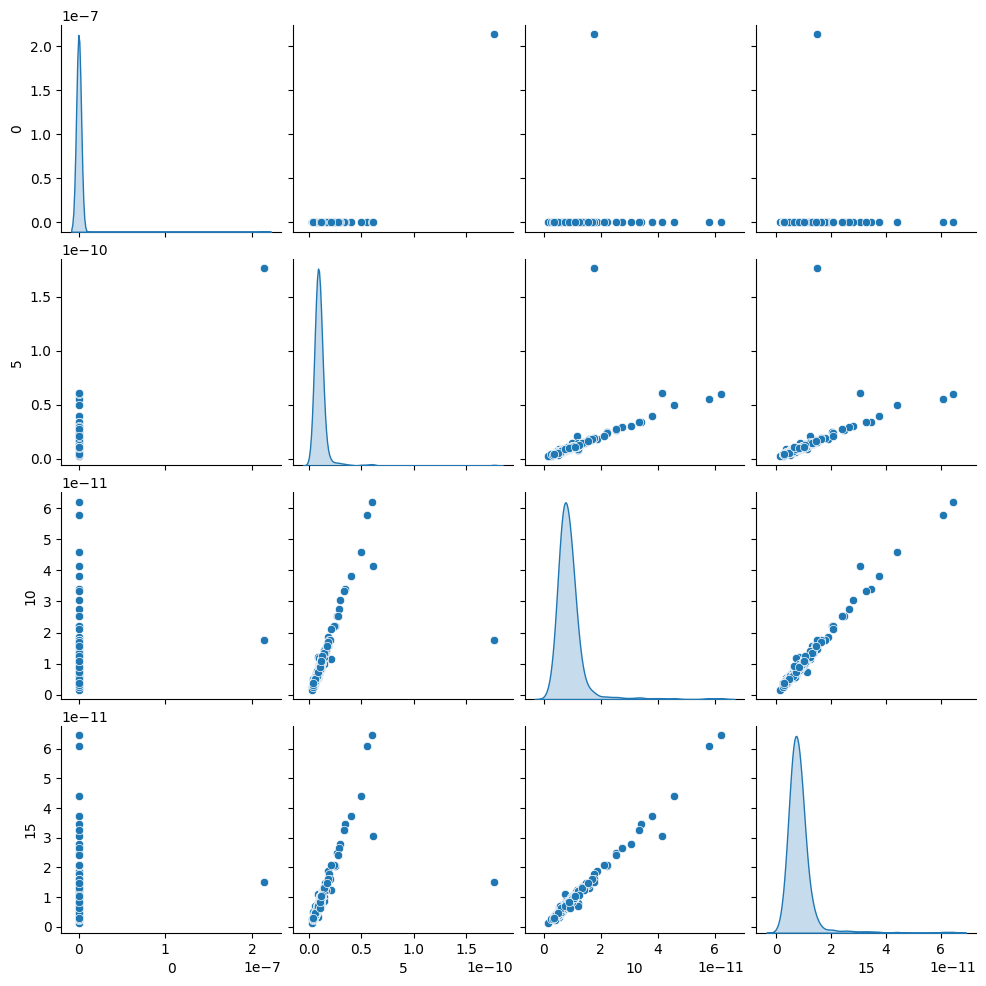

In [71]:

# VIsualize train_dataset
sns.pairplot(train_dataset[[0, 5, 10, 15]], diag_kind="kde")

# Statistic feature of train_dataset
train_stats = train_dataset.describe()
train_stats.pop(SELECTED_LABEL)
train_stats = train_stats.transpose()


1-4. Split train data, train data's label, test data, test data's label

In [72]:

# Detach column from train_dataset & test_dataset
train_labels = train_dataset.pop(SELECTED_LABEL)
test_labels = test_dataset.pop(SELECTED_LABEL)

# Data Normalization - standardization
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# Data Normalization - log10 transform
def norm_log10(x):
  return (np.log10(x))

#--------------------------------------

if(NORMALIZATION == 'norm'):
  normed_train_data = norm(train_dataset)
  normed_test_data = norm(test_dataset)

elif(NORMALIZATION == 'norm_log10'):
  normed_train_data = norm_log10(train_dataset)
  normed_test_data = norm_log10(test_dataset)


In [73]:
train_labels[0:5]

416    3.451541e+08
433    2.642542e+08
467    8.142558e+08
558    2.120874e+09
241    7.192531e+08
Name: OnOff, dtype: float64



---



# 2. Construct DNN structure

In [74]:

# 옵티마이저 인스턴스를 생성하는 함수 정의
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif name == 'sgd':
        return tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif name == 'rmsprop':
        return tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif name == 'adamw':
        return tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    else:
        raise ValueError(f"Unsupported optimizer: {name}")

def build_model():
  model = keras.Sequential([
    layers.Dense(100, kernel_regularizer=REGULARIZATION_NAME, activation=ACTIVATION_FUNCTION, input_shape=[len(train_dataset.keys())]),
    layers.Dropout(DROP_OUT),
    layers.Dense(100, kernel_regularizer=REGULARIZATION_NAME, activation=ACTIVATION_FUNCTION),
    layers.Dropout(DROP_OUT),
    layers.Dense(50, kernel_regularizer=REGULARIZATION_NAME, activation=ACTIVATION_FUNCTION),
    layers.Dropout(DROP_OUT),
    layers.Dense(1)
  ])

  OPTIMIZER = get_optimizer(OPTIMIZER_NAME, LEARNING_RATE)
  OPTIMIZER.build(model.trainable_variables)

  model.compile(loss=LOSS_FUNCTION,
                optimizer=OPTIMIZER,
                metrics=PERFORMANCE)
  return model


model = build_model()
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 100)               30200     
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 100)               10100     
                                                                 
 dropout_22 (Dropout)        (None, 100)               0         
                                                                 
 dense_30 (Dense)            (None, 50)                5050      
                                                                 
 dropout_23 (Dropout)        (None, 50)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                



---



# 3. train

In [75]:

# While each epoch ended, print dot(.) to visualize train process
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('.')
    print('', end='')

# Training
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = BATCH_SIZE,
  callbacks=[PrintDot()])


.
.
.
.
.
.
.
.
.
.


 3-1. Visualize model training process

In [76]:

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mse,mae,mape,val_loss,val_mse,val_mae,val_mape,epoch
995,6.438213e+18,6.438213e+18,692816384.0,94.984940,6.748498e+17,6.748498e+17,555814720.0,99.265686,995
996,6.438184e+18,6.438184e+18,692175680.0,94.834625,6.744303e+17,6.744303e+17,555076544.0,99.087326,996
997,6.438086e+18,6.438086e+18,691456896.0,94.670372,6.740618e+17,6.740618e+17,554423936.0,98.929680,997
998,6.438125e+18,6.438125e+18,690692160.0,94.494766,6.735895e+17,6.735895e+17,553581568.0,98.726151,998
999,6.438091e+18,6.438091e+18,689829120.0,94.294128,6.731145e+17,6.731145e+17,552727680.0,98.519882,999


3-2. Training without EarlyStopping callback

Plot has been saved to /content/drive/My Drive/DNN_Hyperparameter/'OnOff'_'20240530_155827_247268'/plot_20240530_155957_119935.png


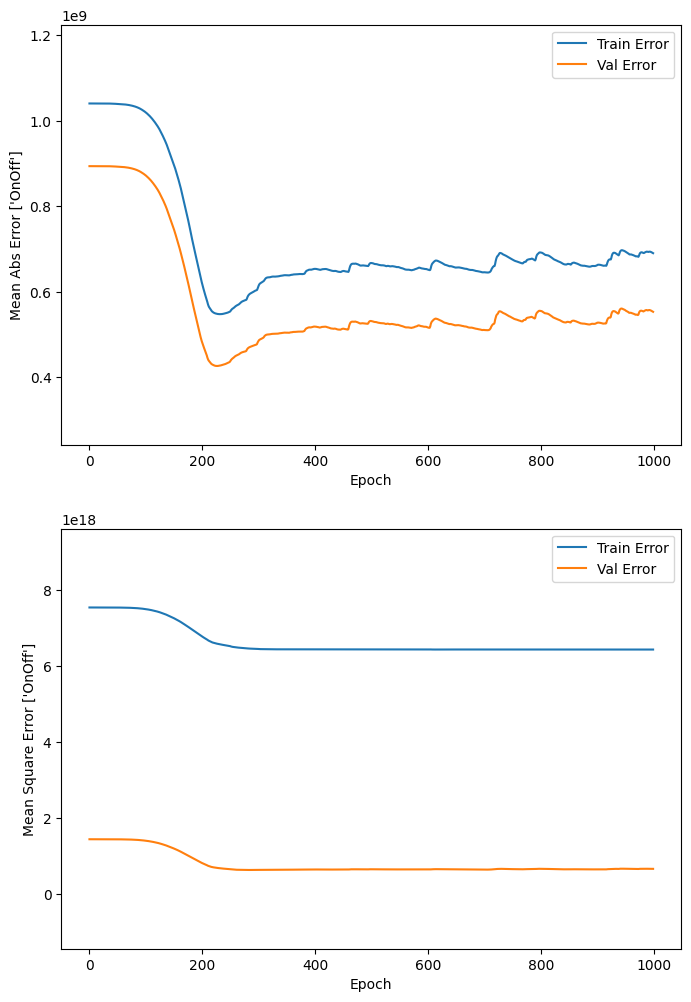

In [77]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  # xlim과 ylim 설정
  mae_max_value = max(np.max(hist['mae']), np.max(hist['val_mae']))
  mse_max_value = max(np.max(hist['mse']), np.max(hist['val_mse']))
  mae_min_value = min(np.min(hist['mae']), np.min(hist['val_mae']))
  mse_min_value = min(np.min(hist['mse']), np.min(hist['val_mse']))

  if(SELECTED_LABEL == 'OnOff'):
    mae_margin = 0.3 * (mae_max_value - mae_min_value)  # 여유 공간 설정
    mse_margin = 0.3 * (mse_max_value - mse_min_value)
  else:
    mae_margin = 0
    mse_margin = 0

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel(f"Mean Abs Error ['{SELECTED_LABEL}']")
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([mae_min_value - mae_margin, mae_max_value + mae_margin])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel(f"Mean Square Error ['{SELECTED_LABEL}']")
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([mse_min_value - mse_margin, mse_max_value + mse_margin])
  plt.legend()

  #시각자료 저장
  plot_figure = plt.gcf()
  save_plot_to_file(plot_figure,folder_path)

  plt.show()

plot_history(history)


3-3. Train with EarlyStopping callback

.
.
.
.
.
Plot has been saved to /content/drive/My Drive/DNN_Hyperparameter/'OnOff'_'20240530_155827_247268'/plot_20240530_160022_161499.png


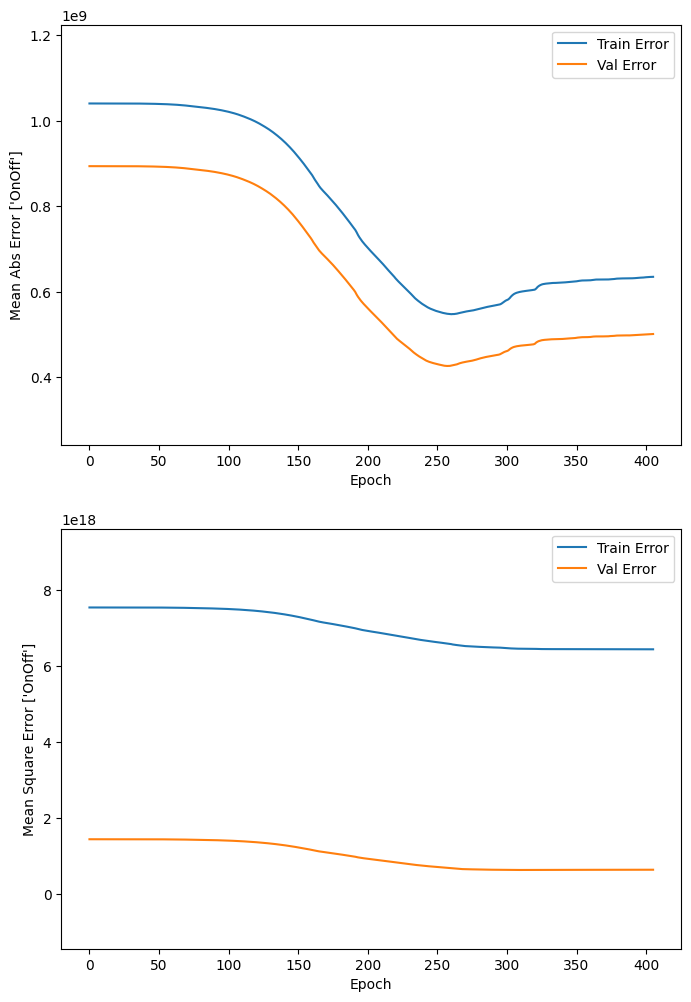

In [78]:
model = build_model()

# patience parameter is a epoch size for checking performance improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

# train
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size = BATCH_SIZE,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)



---



# 5. Test

In [79]:

# For model evaluation, change Pandas(DataFrame) to Numpy with float type
normed_test_data_array = normed_test_data.to_numpy().astype(float)

# Test
loss, mae, mse, mape = model.evaluate(normed_test_data_array, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))


4/4 - 0s - loss: 272823332028547072.0000 - mse: 272823332028547072.0000 - mae: 417941600.0000 - mape: 96.9443 - 256ms/epoch - 64ms/step
테스트 세트의 평균 절대 오차: 272823332028547072.00


5-1. Visualize Prediction (with test data)

4/4 [==============================] - 0s 4ms/step
[9.9734515e+08 9.9209555e+08 9.8643840e+08 9.9272262e+08 1.0078367e+09]
Plot has been saved to /content/drive/My Drive/DNN_Hyperparameter/'OnOff'_'20240530_155827_247268'/plot_20240530_160023_634225.png


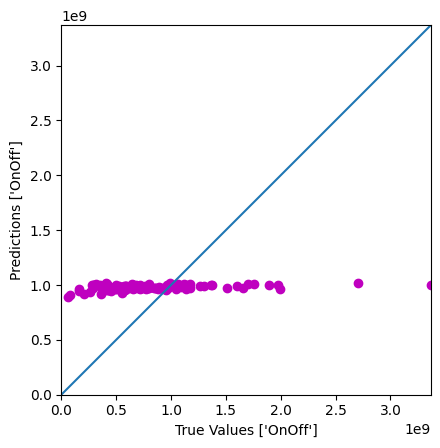

In [80]:

test_predictions = model.predict(normed_test_data).flatten()
print(test_predictions[0:5])


# 색깔 지정

plot_color = ['r','g','b','m']

if(SELECTED_LABEL == 'Vth'):
  COLOR = plot_color[0]
elif(SELECTED_LABEL == 'Mobility'):
  COLOR = plot_color[1]
elif(SELECTED_LABEL == 'S-Slope'):
  COLOR = plot_color[2]
else:
  COLOR = plot_color[3]

# 산포도 그리기
plt.scatter(test_labels, test_predictions, color=COLOR)
plt.xlabel(f"True Values ['{SELECTED_LABEL}']")
plt.ylabel(f"Predictions ['{SELECTED_LABEL}']")
plt.axis('equal')
plt.axis('square')

# xlim과 ylim 설정
max_value = max(np.max(test_labels), np.max(test_predictions))
min_value = min(np.min(test_labels), np.min(test_predictions))
plt.xlim([0, max_value])
plt.ylim([0, max_value])


# 대각선 1:1 라인 그리기
_ = plt.plot([0, max_value], [0, max_value])

#시각자료 저장
plot_figure = plt.gcf()
save_plot_to_file(plot_figure,folder_path)


# 그래프 보여주기
plt.show()


In [81]:

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels, test_predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Mean Squared Error (MSE)
mse = mean_squared_error(test_labels, test_predictions)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# R² Score
r2 = r2_score(test_labels, test_predictions)
print(f'R² Score: {r2:.4f}')

# MAPE
mape = mean_absolute_percentage_error(test_labels, test_predictions)
print(f'MAPE : {mape:.4f}')

Mean Absolute Error (MAE): 417941546.6573
Mean Squared Error (MSE): 272823335750239808.0000
Root Mean Squared Error (RMSE): 522324933.1118
R² Score: -0.1470
MAPE : 0.9694


[9.97345152e+08 9.92095552e+08 9.86438400e+08 9.92722624e+08
 1.00783667e+09 1.01562598e+09 9.64564224e+08 9.86610304e+08
 9.96816512e+08 9.95372416e+08 9.99054912e+08 9.99308608e+08
 1.00087117e+09 1.00539008e+09 1.00822298e+09 8.93200512e+08
 9.69508864e+08 1.01193331e+09 1.01648736e+09 9.73482752e+08
 1.00340941e+09 1.00761677e+09 1.00647360e+09 9.73748032e+08
 9.83076416e+08 9.61241472e+08 9.84275392e+08 9.11809472e+08
 9.78684032e+08 9.59905344e+08 9.64126336e+08 9.75581504e+08
 9.76852416e+08 9.86429760e+08 9.95337472e+08 9.60743424e+08
 1.01027610e+09 9.88568576e+08 9.83298880e+08 9.67365120e+08
 9.73085696e+08 9.66868480e+08 9.50015680e+08 9.91081728e+08
 9.94533376e+08 9.73444672e+08 9.93752192e+08 9.91836032e+08
 9.73645568e+08 9.93368320e+08 9.90065024e+08 9.97021504e+08
 1.00014381e+09 9.89106112e+08 9.83057344e+08 9.82368000e+08
 9.83303040e+08 9.91802880e+08 1.00592339e+09 1.00115853e+09
 1.00333376e+09 1.00086611e+09 1.00760973e+09 1.00423533e+09
 1.01589171e+09 9.836032

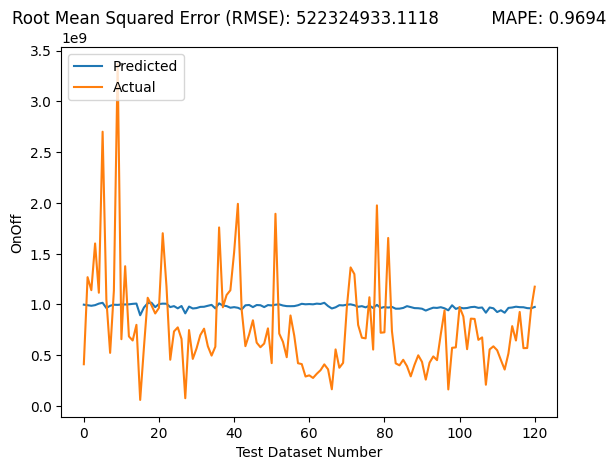

In [82]:
# Test Results Visualization setting
print(test_predictions)
print(test_labels)
plt.figure(5)
plt.title(f'Root Mean Squared Error (RMSE): {rmse:.4f}          MAPE: {mape:.4f}')
plt.plot(list(range(len(test_predictions))), test_predictions, label='Predicted')
plt.plot(list(range(len(test_predictions))), test_labels, label='Actual')
plt.xlabel('Test Dataset Number')
plt.ylabel(SELECTED_LABEL)
plt.legend(loc = 'upper left')

#시각자료 저장
plot_figure = plt.gcf()
save_plot_to_file(plot_figure,folder_path)

Saving data

In [83]:
# 예시 데이터
selected_label_data = f" selected label = '{SELECTED_LABEL}'\n"
formatted_data = f" normalization = '{NORMALIZATION}'\n optimizer = '{OPTIMIZER_NAME}'\n activation function = '{ACTIVATION_FUNCTION}'\n loss function = '{LOSS_FUNCTION}'\n train metrics='{PERFORMANCE}'\n epcohs = '{EPOCHS}'\n batch size = '{BATCH_SIZE}'\n lr = '{LEARNING_RATE}'\n random state = '{RANDOM_STATE}'\n patience = '{PATIENCE}'\n regularization name = '{REGULARIZATION_NAME}'\n regularization dense = '{REGULARIZATION}'\n drop out = '{DROP_OUT}'\n"
loss_data = f" TEST\n\n rmse loss : '{rmse}'\n MAPE loss : '{mape}'"

# 새로운 파일로 데이터 저장
save_data_to_file(selected_label_data, folder_path)
save_data_to_file(formatted_data, folder_path)
save_data_to_file(loss_data, folder_path)


Data has been saved to /content/drive/My Drive/DNN_Hyperparameter/'OnOff'_'20240530_155827_247268'/data_20240530_160024_809686.txt
Data has been saved to /content/drive/My Drive/DNN_Hyperparameter/'OnOff'_'20240530_155827_247268'/data_20240530_160024_827115.txt
Data has been saved to /content/drive/My Drive/DNN_Hyperparameter/'OnOff'_'20240530_155827_247268'/data_20240530_160024_838416.txt
